In [1]:
import re
import os
import csv
import healpy as hp
import numpy as np
import pandas as pd
from scipy.stats import linregress
from itertools import chain

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
% matplotlib inline

import sys
if sys.platform=='darwin':
    top_path='/Users/codydirks/PGCC/'
else:
    top_path='/DataDisk/datafiles/PGCC_HST/'

x1d_dir=top_path+'x1d_files/'

c=300000.

# Sightline | NH2 | N_Cl | N_O
sheffer_data=[('HD23180',20.61,13.75,17.76),
     ('HD23478',20.57,14.85,17.71),
     ('HD24398',20.67,14.42,17.77),
    ('HD112999',20.11,13.53,17.76),
    ('HD124314',20.52,14.20,18.21),
    ('HD147683',20.74,14.47,17.88)
     ]

# Sightline | N(H I) | N(H2)
jenkins_data=[
    ( 'HD23180',20.88,20.60),
    ( 'HD23478',20.71,20.48),
    ( 'HD24398',20.80,20.67),
    ('HD112999',np.nan,20.11),
    ('HD124314',21.41,20.52),
    ('HD147683',21.20,20.68),
    ('HD148594',np.nan,19.88),
    ('HD185418',21.19,20.71),
    ('HD210839',21.15,20.84),
    ('HD232522',21.08,20.22),
]

# Sightline | CO | 13CO
sheffer_isotope_data=[('HD22951', 1.83e14,2.31e12),
('HD23180', 6.78e14,9.32e12),
('HD23478', 8.05e14,12.0e12),
('HD24398', 17.9e14,16.5e12),
('HD24534', 158e14,186.0e12),
('HD27778', 123e14,183.0e12),
('HD99872', 4.54e14,5.6e12),
('HD147683', 80.3e14,113e12),
('HD148937', 3.81e14,6.6e12),
('HD177989', 4.4e14,8.35e12),
('HD192035', 13.9e14,27.5e12),
('HD198781', 16.6e14,27.7e12),
('HD203374A', 25.5e14,33.3e12),
('HD203532', 45.6e14,111e12),
('HD206267A', 134e14,322e12),
('HD207198', 31.6e14,66.1e12),
('HD207308', 83.2e14,118e12),
('HD207538', 23.4e14,45.6e12),
('HD208266', 116e14,138e12),
('HD210839', 27.5e14,35.4e12)]


class LineInfo(object):
    def __init__(self,dat_line,err_line):
        dat=dat_line.split()
        if len(dat)==10:
            self.ion=dat[0]
            self.n=float(dat[1])
            self.b=float(dat[2])
            self.wav=float(dat[3])
            self.v=float(dat[4])
            self.n_flag=int(dat[5])
            self.b_flag=int(dat[6])
            self.v_flag=int(dat[7])
            self.eqw=float(dat[8])
            self.tot_eqw=float(dat[9])
        elif len(dat)<10:
            self.ion=dat_line[0:10]
            self.n=float(dat_line[10:20])
            self.b=float(dat_line[20:28])
            self.wav=float(dat_line[28:38])
            self.v=float(dat_line[38:48])
            self.n_flag=int(dat_line[48:52])
            self.b_flag=int(dat_line[52:54])
            self.v_flag=int(dat_line[54:56])
            self.eqw=float(dat_line[56:64])
            self.tot_eqw=float(dat_line[64:])
        
        errs=err_line.split()
        self.n_err=float(errs[0])
        self.b_err=float(errs[1])
        self.v_err=float(errs[2])
        
    def __repr__(self):
        return self.ion
    def __str__(self):
        return self.ion

def load_results(filename):
    gaia_filenames=[top_path+'gaia_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_data=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')[1].data
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gaia_entry=fits.open(gaia_filenames[fl])[1].data[idx]
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    return sightline_pgcc_gaia_data

# Returns the velocity shift necessary to convert Helio to LSR
# i.e. returns (V_lsr - V_helio)
def HelioToLSR(target_ra_deg, target_dec_deg):
    Vsun=19.7
    a0=271.0*np.pi/180.
    d0=30.0*np.pi/180.
    a=target_ra_deg*np.pi/180.
    d=target_dec_deg*np.pi/180.
    #shift=Vsun*(np.cos(a-a0)*np.cos(a0)*np.cos(a)+np.sin(d0)*np.sin(d))
    shift=Vsun*(np.cos(a0)*np.cos(d0)*np.cos(a)*np.cos(d)
                +np.sin(a0)*np.cos(d0)*np.sin(a)*np.cos(d)
                +np.sin(d0)*np.sin(d))
    return shift


def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))


def get_cfa_vels_spec(data,hdr,glon,glat):
    cfa_vels=hdr['CRVAL1']+hdr['CDELT1']*np.arange(hdr['NAXIS1'])
    cfa_glons=hdr['CRVAL2']+hdr['CDELT2']*np.arange(hdr['NAXIS2'])
    cfa_glats=hdr['CRVAL3']+hdr['CDELT3']*np.arange(-hdr['NAXIS3']/2+1,hdr['NAXIS3']/2+1)
    
    if glon > 180:
        glon=glon-360
    glon_idx=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-glon))
    glat_idx=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-glat))
    cfa_spec=data[glat_idx,glon_idx,:]
    return cfa_vels,cfa_spec
    
    
def get_co_map(data,hdr,glon,glat,box,vel=0,vel_width=20):
    cfa_vels=hdr['CRVAL1']+hdr['CDELT1']*np.arange(hdr['NAXIS1'])
    cfa_glons=hdr['CRVAL2']+hdr['CDELT2']*np.arange(hdr['NAXIS2'])
    cfa_glats=hdr['CRVAL3']+hdr['CDELT3']*np.arange(-hdr['NAXIS3']/2+1,hdr['NAXIS3']/2+1)
    
    if glon > 180:
        glon=glon-360

    min_vel=vel-vel_width
    max_vel=vel+vel_width
    min_vel_idx=min(range(len(cfa_vels)), key=lambda i: abs(cfa_vels[i]-min_vel))
    max_vel_idx=min(range(len(cfa_vels)), key=lambda i: abs(cfa_vels[i]-max_vel))

    # Isolate a box around the sightline
    box=2.0
    glon_idx=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-glon))
    glat_idx=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-glat))
    min_glon=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-(glon+box/2.)))
    max_glon=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-(glon-box/2.)))
    min_glat=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-(glat-box/2.)))
    max_glat=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-(glat+box/2.)))
    #print cfa_data[min_vel_idx:max_vel_idx,min_glon:max_glon,min_glat:max_glat]
    cube=data[min_glat:max_glat,min_glon:max_glon,min_vel_idx:max_vel_idx]
    cube[np.isnan(cube)]=0
    dat=np.sum(cube,axis=2)
    #if cfa_glons[min_glon] < 0:
    #    return dat[::-1,:],[cfa_glons[min_glon]+360,cfa_glons[max_glon]+360,cfa_glats[min_glat],cfa_glats[max_glat]]
    #else:
    #return dat[::-1,:],[cfa_glons[min_glon],cfa_glons[max_glon],cfa_glats[min_glat],cfa_glats[max_glat]]
    return dat[::-1,:],[1.1,-1.1,-1.1,1.1]



def parse_results_file(filename):
    ids=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
    ions=[]
    with open(filename) as myfile:
        lines=[x.strip() for x in myfile.readlines()]
        for i in range(len(lines)):
            if len(lines[i].strip())>0:
                dat=lines[i].split()
                if any([dat[0]==x for x in ids]) or dat[0].startswith('CO_'):
                    ions.append(LineInfo(lines[i],lines[i+1]))
    return ions

def get_sightline_fits6p_results(sightline, ion):
    del_v_tol=1.5
    data=[]
    fits6p_prefix=get_fits6p_ion(ion)
    for fl in [x for x in os.listdir(x1d_dir+sightline+'/E140H') if x.startswith(fits6p_prefix) and x.endswith('.txt')]:
        ions=parse_results_file(x1d_dir+sightline+'/E140H/'+fl)
        if 'CO' in ion:
            selected_ions=[i for i in ions if i.ion.startswith(ion)]
        else:
            selected_ions=[i for i in ions if i.ion==ion]
        data.append((fl,selected_ions))
    return data


def get_fits6p_ion(strng):
    return strng.strip('*').replace('_','').lower().replace('i','I').replace('nI','ni').strip(']')

def get_table_ion(strng):
    return strng.replace('_I]','').replace('_II','').replace('_I','')

In [2]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    primary_sightlines.append('HD203532')
    
with open('secondary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    secondary_sightlines=inp.next()
    
with open('in_front_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    in_front_sightlines=inp.next()


In [3]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    
filename='sightline_pgcc_gaia_results.txt'
all_data=load_results(filename)
all_data.sort(key=lambda x: (x[0][0],int(re.search(r'\d+',x[0]).group())))

primary_sample=[x for x in all_data if x[0] in primary_sightlines]
len(primary_sample)

22

In [4]:
sheffer_data=pd.read_csv('sheffer_co_h2.csv')

In [122]:
del_v_tol=1.5
ion_list=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
ns_dict={}
info={'Sightline':[],'R_dist':[],'Velocity':[]}
for ion in ion_list:
    ns_dict[ion]=0
    
    info[get_table_ion(ion)]=[]
    info[get_table_ion(ion)+'_err']=[]
    
all_data=pd.DataFrame(info)

for sl in primary_sample:
    info['Sightline']=sl[0]
    ra,dec=sl[1]
    galcoords=SkyCoord(ra=ra,dec=dec).galactic
    pgcc=sl[2]
    info['R_dist']=round(get_r_dist(pgcc,ra.value,dec.value),2)
    
    data_dict={}
    for ion in ion_list:
        data_dict[ion]=get_sightline_fits6p_results(info['Sightline'],ion)
    
    vel_comps=[]
    [vel_comps.append(v) for v in [y.v for y in chain(*[x[1] for x in (data_dict['CO']+data_dict['13CO']+data_dict['O_I]']+data_dict['Cl_I'])])]
     if any([abs(v-z)<del_v_tol for z in vel_comps])==False]
        
    vel_comps.sort()
    for v in vel_comps:
        n_dict={}
        comps_dict={}
        # Initialize components and columns to zero
        for ion in ion_list:
            n_dict[ion]=0
            n_dict[ion+'_err']=0
            comps_dict={}
        
        # Iterate over ions and get nearest component, then add columns in that component
        for ion in ion_list:
            for entry in data_dict[ion]:
                comps_dict[ion]=[c for c in entry[1] if abs(c.v-v)<del_v_tol]
                if len(comps_dict[ion])>0:
                    n_tot=sum([x.n for x in comps_dict[ion]])
                    n_err=np.sqrt(sum([x.n_err*x.n_err for x in comps_dict[ion]]))
                    n_dict[ion]=round(np.log10(n_tot),3)
                    n_dict[ion+'_err']=0.434*n_err/n_tot
                    #n_err=np.sqrt(sum([x.n_err*x.n_err for x in comps_dict[ion]]))
                    break
            info[get_table_ion(ion)]=n_dict[ion]
            info[get_table_ion(ion)+'_err']=n_dict[ion+'_err']
        info['Velocity']=v
        new_row=pd.DataFrame({key:[info[key]] for key in info})
        all_data=pd.concat([all_data,new_row])

cols=['Sightline','R_dist','Velocity']+list(chain.from_iterable([[get_table_ion(i),get_table_ion(i)+'_err'] for i in ion_list]))
all_data=all_data[cols].reset_index(drop=True)
all_data=all_data.replace(-np.inf,0)

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: divide by zero encountered in double_scalars


In [123]:
all_data['H_tot']=np.where(all_data['O']>0,np.log10((10**6/305.)*10**(all_data['O'])),0).round(3)
all_data['H_2']=np.where(all_data['Cl']>0, ((all_data['Cl']+3.7)/0.87),0.).round(3)
all_data['f_H2']=np.where((all_data['H_tot']>0) & (all_data['H_2']>0),10**(np.log10(2.)+all_data['H_2']-all_data['H_tot']),0.0).round(3)
all_data['CO/H2']=np.where((all_data['H_2']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['H_2']),0.0)
all_data['12CO/13CO']=np.where((all_data['13CO']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['13CO']),0.0).round(3)


1.93915304912e-05
3.46135084689e-06


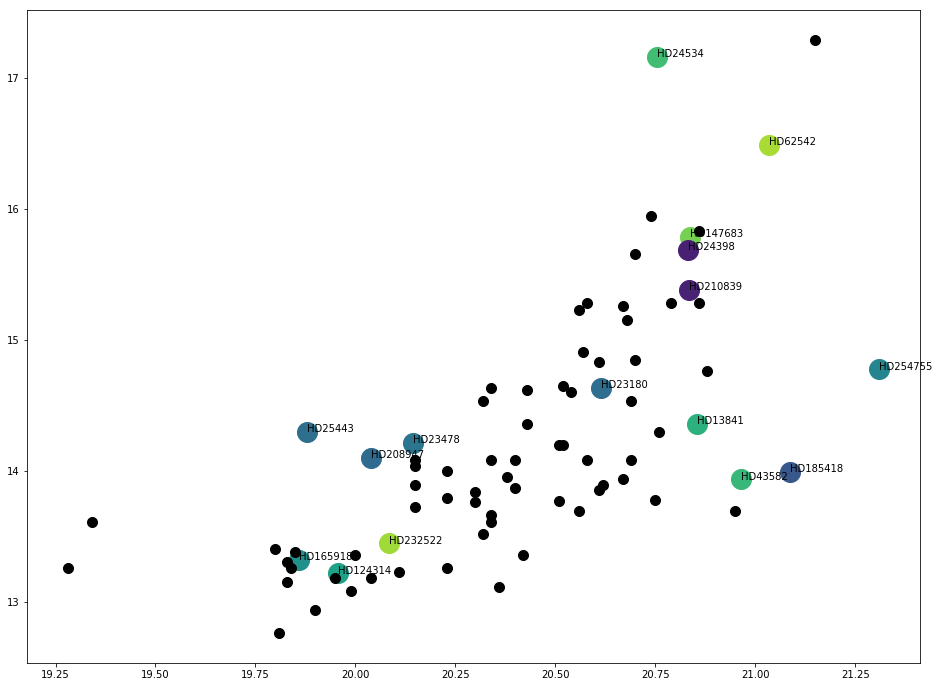

In [7]:
# CO-to-H2 plot
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
cm = plt.cm.get_cmap('viridis_r')

s1=[]
s2=[]

nco_min=12
nco_max=17
ncl_min=13.5 # Below this, Balashev conversion to H2 becomes extremely uncertain
#cut=all_data.loc[(all_data['Cl_I']>ncl_min) & (all_data['13CO']>12)]
cut=all_data[(all_data['CO']>13)&(all_data['R_dist']<20)&(all_data['Cl']>13.5)]
norm=Normalize(vmin=0,vmax=10)
for sl in cut.groupby('Sightline'):
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    x=row['H_2']
    y=row['CO']
    s1.append(10**(row['CO']-row['H_2']))
    col=cm(norm(row['R_dist']))
    subplt.plot(x,y,marker='o',color=col,markersize=20)
    subplt.text(x,y,row['Sightline'])
print
for idx,row in sheffer_data.iterrows():
    subplt.plot(row['H2'],row['CO'],'ko',markersize=10)
    s2.append(10**(row['CO']-row['H2']))
    
print np.mean(s1)
print np.mean(s2)

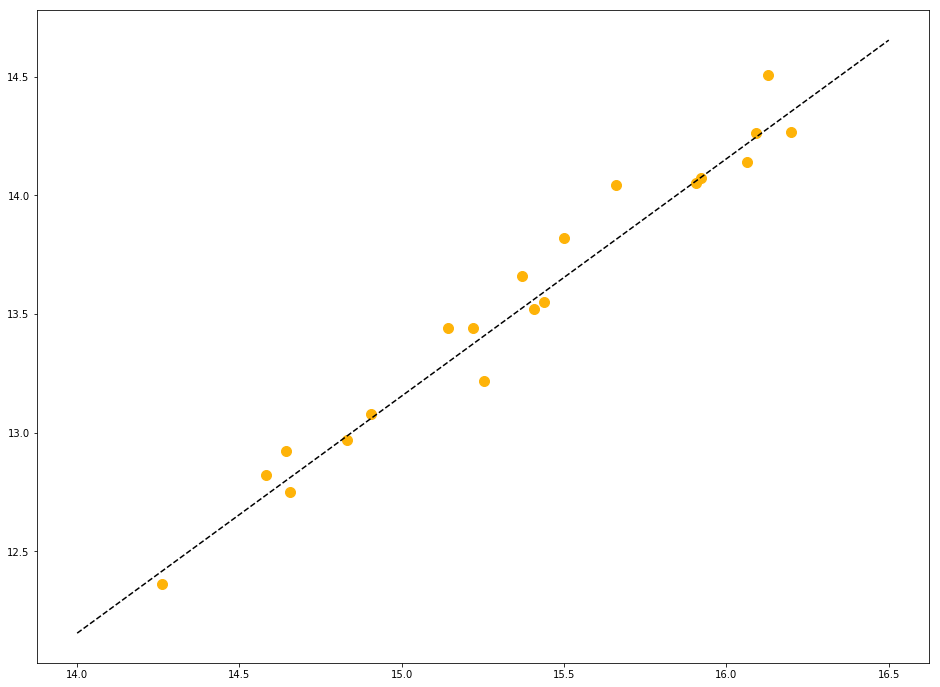

In [11]:
# 12CO/13CO Plots
# Filter results 
nco_min=12
nco_max=17
ncl_min=11 # Below this, Balashev conversion to H2 becomes extremely uncertain
#cut=all_data.loc[(all_data['Cl_I']>ncl_min) & (all_data['13CO']>12)]
cut=all_data.loc[(all_data['12CO/13CO']>0)&(all_data['12CO/13CO']<100)&(all_data['13CO']>13)]



fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
cm = plt.cm.get_cmap('viridis')
subplt.scatter(cut['CO'],cut['13CO'],marker='o',color=blue,s=100)

x2=[]
y2=[]
for entry in sheffer_isotope_data:
    if entry[0] not in cut['Sightline'].values:
        x2.append(np.log10(entry[1]))
        y2.append(np.log10(entry[2]))
subplt.scatter(x2,y2,marker='o',color=amber,s=100)

tx=np.arange(14,17,0.5)
ty=np.array([np.log10((10**x)/70) for x in tx])
subplt.plot(tx,ty,'k--')

Text(0.5,0,u'Log CI')

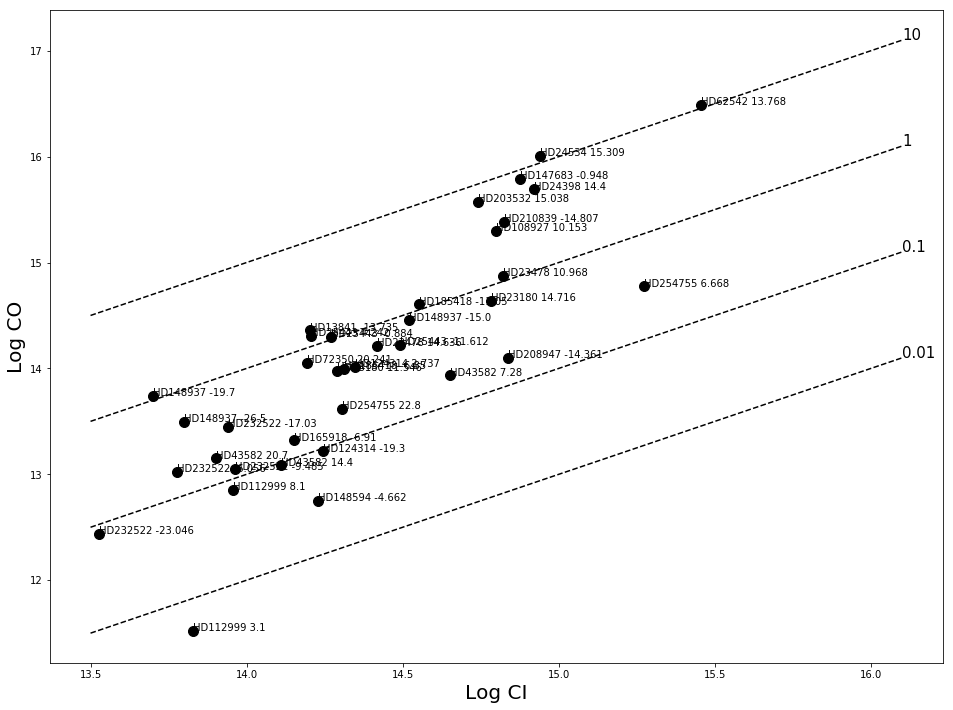

In [124]:
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0) & (all_data['CO']>0)]
for sl,data in cut_data.groupby('Sightline'):
    num_c_comps=len(all_data[(all_data['Sightline']==sl)&(all_data['C']>0)])
    for idx,row in data.iterrows():
        c_tot=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        subplt.plot(c_tot,row['CO'],'ko',markersize=10)
        subplt.text(c_tot, row['CO'], sl+' '+str(row['Velocity']))
        #print '\t',10**(row['CO']-c_tot)
    c_tot=np.log10(np.sum([np.sum([10**row[col] for col in ('C','C*','C**')]) for idx,row in data.iterrows()]))
    co_tot=np.log10(np.sum([10**row['CO'] for idx,row in data.iterrows()]))
    #subplt.plot(c_tot,co_tot,'bo',markersize=10)
    #subplt.text(c_tot,co_tot,sl)
    
tx=np.arange(13.5,16.1,0.1)
for rat in (0.01,0.1,1,10):
    ty=np.array([np.log10(rat*(10**x)) for x in tx])
    subplt.plot(tx,ty,'k--')
    subplt.text(tx[-1],ty[-1],str(rat),fontsize=15)
subplt.set_ylabel('Log CO',fontsize=20)
subplt.set_xlabel('Log CI',fontsize=20)


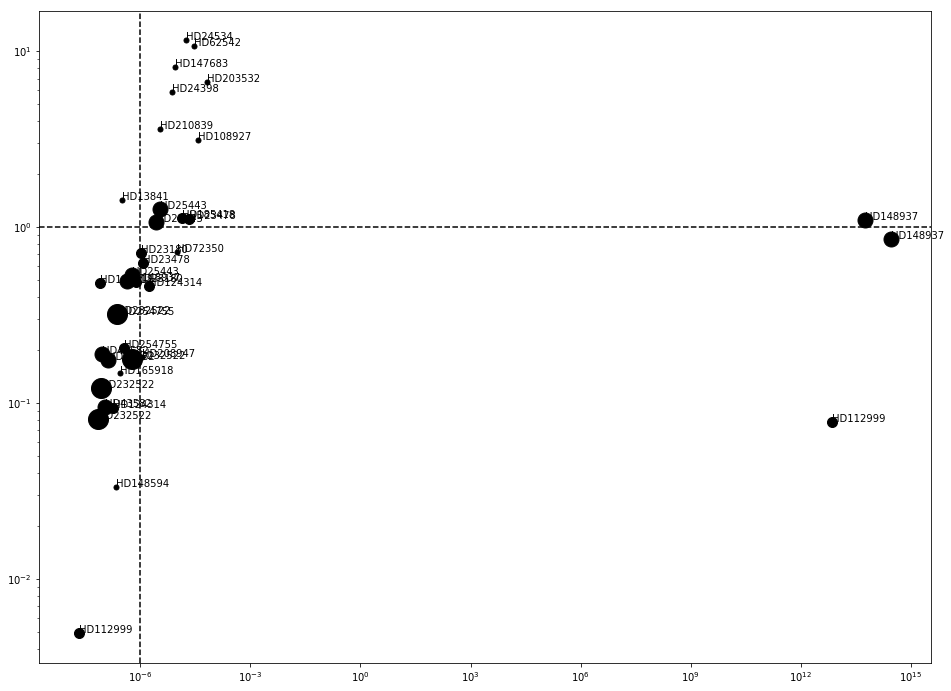

In [125]:
fig=plt.figure(1,figsize=(16,12))

subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0) & (all_data['CO']>0)]
for sl in cut_data.groupby('Sightline'):
    for idx,row in sl[1].iterrows():
        c_tot=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        if len(sl[1])>=1:
            subplt.plot(10**(row['CO']-row['H_2']),10**(row['CO']-c_tot),'ko',markersize=5*len(sl[1]))
            subplt.text(10**(row['CO']-row['H_2']),10**(row['CO']-c_tot),sl[0])

subplt.set_yscale('log')
subplt.set_xscale('log')
#subplt.set_ylim(0.007,100)
#subplt.set_xlim(1e-8,1e-4)
subplt.axvline(1e-6,0,1,color='k',linestyle='--')
subplt.axhline(1.0,0,1,color='k',linestyle='--')

In [115]:
for sl in primary_sightlines:
    print sl,
    files=os.listdir('/Users/codydirks/PGCC/x1d_files/'+sl+'/E140H')
    for fl in files:
        if '1270' in fl:
            print fl.split('.')[0],
    print

HD13841 cI_1270_results HD13841_1270
HD23180
HD23478 cI_1270_results cI_1270_results HD23478_1270
HD24398
HD24534 cI_1270_results HD24534_1270
HD25443 cI_1270_results HD25443_1270
HD43582 cI_1270_results cI_1270_results HD43582_1270
HD62542 cI_1270_results HD62542_1270 cI_1270_results HD62542_1270
HD72350 HD72350_1270
HD108927 cI_1270_results HD108927_1270
HD112999 HD112999_1270
HD124314 HD124314_1270
HD147683 HD147683_1270
HD148594 HD148594_1270
HD148937 HD148937_1270
HD165918
HD185418 cI_1270_results HD185418_1270
HD203532
HD208947 HD208947_1270
HD210839 cI_1270_results HD210839_1270 HD210839_1270 cI_1270_results
HD232522 cI_1270_results cI_1270_results HD232522_1270
HD254755 HD254755_1270


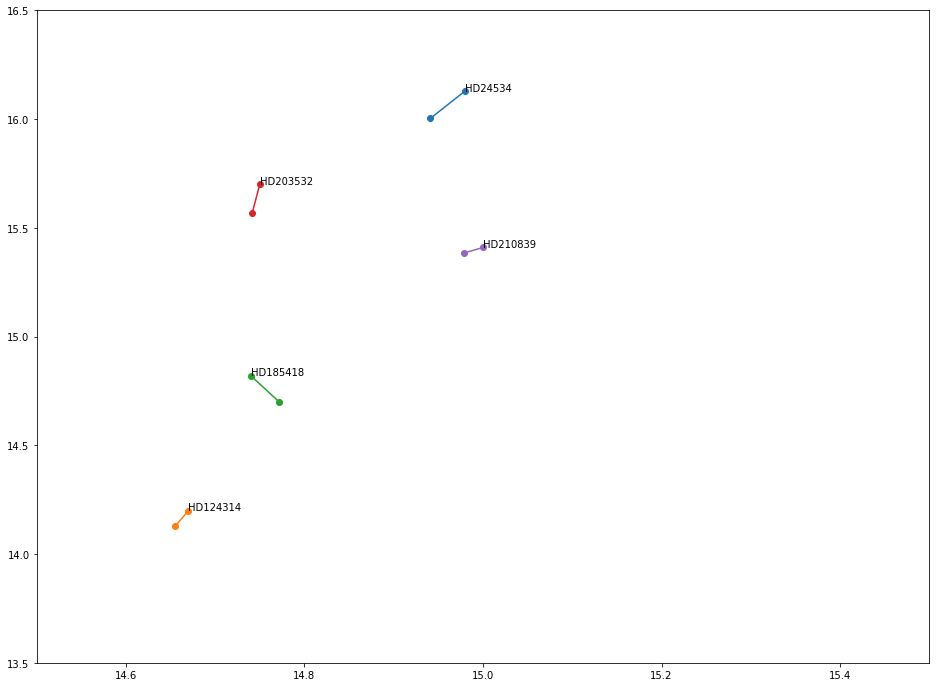

In [79]:
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
subplt.set_ylim(13.5,16.5)
subplt.set_xlim(14.5,15.5)

burgh_data=pd.read_csv('burghtable2.csv')
for idx, burgh_row in burgh_data.iterrows():
    if burgh_row['Sightline'] in all_data['Sightline'].unique():
        cs_to_sum=all_data[all_data['Sightline']==burgh_row['Sightline']]
        cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in cs_to_sum.iterrows()]
        c_tot=np.log10(np.sum([10**n for n in cs]))
        
        cos_to_sum=all_data[all_data['Sightline']==burgh_row['Sightline']]
        co_tot=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
        
        subplt.plot([float(burgh_row['CI']),c_tot],[float(burgh_row['CO']),co_tot],marker='o')
        subplt.text(float(burgh_row['CI']),float(burgh_row['CO']),burgh_row['Sightline'])

In [130]:
all_data[(all_data['C']>0) & (all_data['CO']>0)][['Sightline','C','CO','H_2']]

,Sightline,C,CO,H_2
5,HD13841,14.053,14.359,20.854
8,HD23180,14.158,13.976,20.092
9,HD23180,14.544,14.636,20.615
10,HD23478,14.672,14.870,19.541
11,HD23478,14.279,14.213,20.144
12,HD24398,14.816,15.690,20.831
14,HD24534,14.761,16.004,20.754
15,HD25443,14.352,14.223,20.459
16,HD25443,14.196,14.299,19.879
17,HD25443,14.079,14.309,19.768


In [85]:
for sl,rows in all_data.groupby('Sightline'):
    print sl,len(rows)

HD108927 1
HD112999 2
HD124314 5
HD13841 8
HD147683 2
HD148594 1
HD148937 7
HD165918 2
HD185418 4
HD203532 1
HD208947 2
HD210839 7
HD23180 2
HD232522 4
HD23478 2
HD24398 1
HD24534 2
HD25443 3
HD254755 7
HD43582 3
HD62542 1
HD72350 4


In [64]:
10**(14.2)

158489319246111.1

In [71]:
np.log10(8.73E14)

14.94101424370557